In [53]:
import multiprocessing

import pandas as pd
import numpy as np
import itertools
import importlib
import missingno as msno
import matplotlib.pyplot as plt
import warnings
import imblearn
import spacy
import re
from joblib import dump, load
from collections import Counter



from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, precision_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, \
    cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, roc_curve, auc, precision_recall_curve, classification_report

from sklearn.decomposition import TruncatedSVD

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC

from Project.utils.analysis.ml_utils import StanceCrossPredictor
from Project.utils.storage import youtube_db as db
from Project.utils.analysis import ml_utils as ml
from Project.utils.analysis import text_classifier as tc

importlib.reload(db)
importlib.reload(ml)
importlib.reload(tc)

trump_podcasts = [
    "xrFdHO7FH8w",
    "blqIZGXWUpU",
    "s11uIW7wi-E",
    "vC5cHjcgt5g",
    "G80iLTctFuY",
    "qCbfTN-caFI",
    "Ry1IjOft95c",
    "S7BTdUaNQM8",
    "1SsmPh8gCxU",
    "-dmwG54QsKc",
    "nwQil7tcImI",
    "G9lXnwuZ2qs",
    "hBMoPUAeLnY"
]

harris_podcasts = [
    "_KCRsjPCiCI",
    "bzThwqnQJDY",
    "7L4sts7I3xI",
    "pNbwMrBMGgE",
    "Vu5yD3fu6A8",
]

youtube_db = db.SQLiteYoutubeSaver(db_name='../db/youtube.db')

### 1. Load the Dataset

In [38]:
youtube_db.cursor.execute(f"""
SELECT video_id, content, gemini_label, sentiment, emotion, bias, leaning, is_political
FROM CommentAnalysis JOIN Comments on Comments.id = CommentAnalysis.id
WHERE gemini_label IS NOT NULL
""")

data = youtube_db.cursor.fetchall()

df = pd.DataFrame(data)
df.columns = ['video_id', 'content', 'label', 'sentiment', 'emotion', 'bias', 'leaning', 'is_political']
df['podcast_guest'] = ['Trump' if video_id in trump_podcasts else 'Harris' for video_id in df['video_id']]
df['rep_label'] = [1 if l == 'Republican' else 0 for l in df['label']]
df['dem_label'] = [1 if l == 'Democratic' else 0 for l in df['label']]
df.drop('video_id', axis=1, inplace=True)

df

,content,label,sentiment,emotion,bias,leaning,is_political,podcast_guest,rep_label,dem_label
0,Best Podcast of All-time? 🤔🔥,Republican,Positive,joy,RIGHT,RIGHT,0,Trump,1,0
1,Definitely my favorite!,Republican,Positive,joy,RIGHT,LEFT,0,Trump,1,0
2,"No, best guest",Republican,Positive,joy,RIGHT,RIGHT,0,Trump,1,0
3,Probably,Neutral,Neutral,anticipation,RIGHT,LEFT,0,Trump,0,0
4,Under 30 seconds,Neutral,Neutral,anticipation,RIGHT,RIGHT,0,Trump,0,0
...,...,...,...,...,...,...,...,...,...,...
18973,@@leroyjetson2329Folks with Caribbean heritage...,Neutral,Negative,anticipation,LEFT,RIGHT,1,Harris,0,0
18974,I am only here for the comment section.,Neutral,Neutral,anger,RIGHT,RIGHT,0,Harris,0,0
18975,😅😂 this comment section is trouble!,Neutral,Negative,anger,RIGHT,LEFT,0,Harris,0,0
18976,@@HI-DEF100 I’ve been looking for a positive c...,Republican,Neutral,sadness,LEFT,LEFT,0,Harris,1,0


In [39]:
X = df[['content', 'podcast_guest', 'sentiment', 'emotion', 'bias', 'leaning', 'is_political']]

y_rep = df['rep_label']
y_dem = df['dem_label']

# A. Republican Classifier

### 2. Split the Dataset

In [5]:
X_train_rep, X_test_rep, y_train_rep, y_test_rep = train_test_split(
    X, y_rep, test_size=0.2, stratify=y_rep, random_state=42, shuffle=True
)

### 3. Preprocessing

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('spacy_vect', ml.SpacyVectorTransformer(), ['content']),
        ('guest_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ['podcast_guest', 'sentiment', 'emotion', 'bias', 'leaning']),
    ]
)

X_train_rep_processed = preprocessor.fit_transform(X_train_rep) # Fit and Transform on Train Set
X_test_rep_processed = preprocessor.transform(X_test_rep) # Only Transform on Test Set


C:\Users\Filippo Corti\miniconda3\envs\SocialMediaMining\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### 4. Pipeline

In [7]:
pipeline = IMBPipeline([
    # Preprocessing is moved outside for computational purposes
    ('sampler', None),
    ('dim_reduction', None),
    ('classifier', LogisticRegression())
])

scoring = {
    'f1': make_scorer(f1_score, zero_division=0),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'roc_auc': make_scorer(roc_auc_score)
}

### 5. Find Best Model with CV

In [8]:
all_configs = ml.get_configurations_grid_for_precision()

print(f"Total pipeline combinations: {len(all_configs)}")

rs_rep = RandomizedSearchCV(
    pipeline,
    param_distributions=all_configs,
    n_iter=20,
    n_jobs=3,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring=scoring,
    error_score='raise',
    refit='precision', # Optimize for precision
    random_state=42,
    verbose=3,
    return_train_score=True
)

rs_rep.fit(X_train_rep_processed, y_train_rep)

best_model = rs_rep.best_estimator_

best_model

Total pipeline combinations: 8
Fitting 3 folds for each of 20 candidates, totalling 60 fits


Pipeline(steps=[('sampler', None), ('dim_reduction', None),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 2, 1: 1}, max_depth=8,
                                        max_features=0.3, min_samples_leaf=30,
                                        min_samples_split=40,
                                        random_state=42))])

In [9]:
# Results

print("TRAINING SET:")
print(classification_report(y_train_rep, best_model.predict(X_train_rep_processed)))

print("TEST SET:")
print(classification_report(y_test_rep, best_model.predict(X_test_rep_processed)))


TRAINING SET:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     10359
           1       0.95      0.06      0.11      4823

    accuracy                           0.70     15182
   macro avg       0.82      0.53      0.47     15182
weighted avg       0.78      0.70      0.59     15182

TEST SET:
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      2590
           1       0.84      0.04      0.08      1206

    accuracy                           0.69      3796
   macro avg       0.76      0.52      0.45      3796
weighted avg       0.74      0.69      0.58      3796



### 6. Find Threshold value for Precision-Recall balance

1847: Precision 0.50 → Recall 0.737 → Threshold 0.190
2140: Precision 0.55 → Recall 0.677 → Threshold 0.235
2406: Precision 0.60 → Recall 0.606 → Threshold 0.278
2628: Precision 0.65 → Recall 0.537 → Threshold 0.313
2852: Precision 0.70 → Recall 0.447 → Threshold 0.348
3472: Precision 0.80 → Recall 0.097 → Threshold 0.467


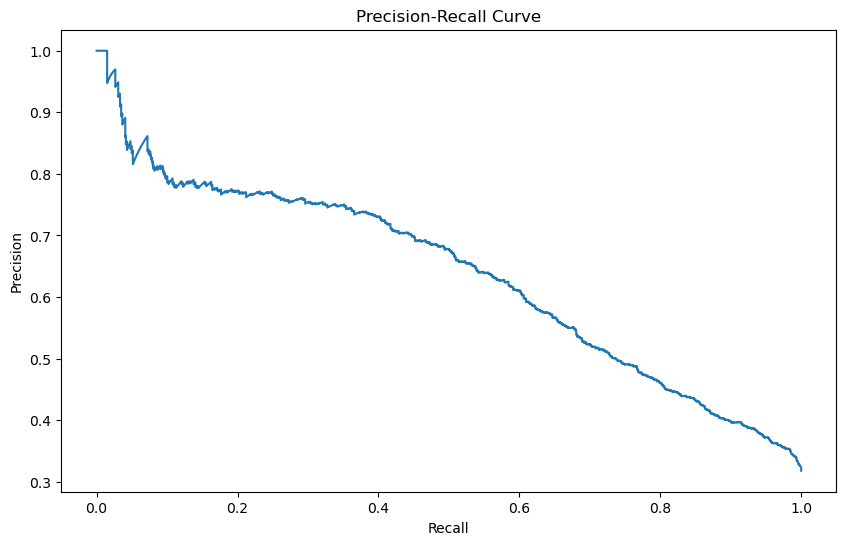

In [10]:
y_proba = rs_rep.predict_proba(X_test_rep_processed)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test_rep, y_proba)

# Plot to see your options
plt.figure(figsize=(10, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

for target_precision in [0.5, 0.55, 0.6, 0.65, 0.7, 0.8]:
    if np.any(precision >= target_precision):
        idx = np.argmax(precision >= target_precision)
        print(f"{idx}: Precision {target_precision:.2f} → Recall {recall[idx]:.3f} → Threshold {thresholds[idx]:.3f}")


In [11]:
best_threshold = 0.348 # Pick manually

y_test_tuned = (y_proba >= best_threshold).astype(int)

print("TEST SET (with Best Threshold):")
print(classification_report(y_test_rep, y_test_tuned))

TEST SET (with Best Threshold):
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      2590
           1       0.70      0.45      0.55      1206

    accuracy                           0.76      3796
   macro avg       0.74      0.68      0.69      3796
weighted avg       0.75      0.76      0.75      3796



### 7. Save the Results

In [12]:
final_model = ml.ClassifierWithThresholdModel(
    pipeline=best_model,
    preprocessor=preprocessor,
    threshold=best_threshold,
)

ml.ClassifierWithThresholdModel.save_model(final_model, '../data/best_model_rep.joblib')

Model exported to ../data/best_model_rep.joblib


# B. Democratic Classifier

### 2. Split the Dataset

In [40]:
X_train_dem, X_test_dem, y_train_dem, y_test_dem = train_test_split(
    X, y_dem, test_size=0.2, stratify=y_dem, random_state=42, shuffle=True
)

### 3. Preprocessing

In [67]:
preprocessor = ColumnTransformer(
    transformers=[
        ('spacy_vect', ml.SpacyVectorTransformer(), ['content']),
        ('guest_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ['podcast_guest', 'sentiment', 'emotion', 'bias', 'leaning']),
    ]
)

X_train_dem_processed = preprocessor.fit_transform(X_train_dem) # Fit and Transform on Train Set

In [ ]:
X_test_dem_processed = preprocessor.transform(X_test_dem) # Only Transform on Test Set

### 4. Pipeline

In [41]:
pipeline = IMBPipeline([
    # Preprocessing is moved outside for computational purposes
    ('sampler', None),
    ('dim_reduction', None),
    ('classifier', LogisticRegression())
])

scoring = {
    'f1': make_scorer(f1_score, zero_division=0),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'roc_auc': make_scorer(roc_auc_score)
}

### 5. Find Best Model with CV

In [44]:
all_configs = ml.get_configurations_grid_for_precision()

print(f"Total pipeline combinations: {len(all_configs)}")

custom_scorer = make_scorer(ml.precision_recall_weighted, greater_is_better=True)

rs_dem = RandomizedSearchCV(
    pipeline,
    param_distributions=all_configs,
    n_iter=20,
    n_jobs=3,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring=custom_scorer,
    error_score='raise',
    refit=True,
    random_state=42,
    verbose=3,
    return_train_score=True
)

rs_dem.fit(X_train_dem_processed, y_train_dem)

best_model = rs_dem.best_estimator_

best_model

Total pipeline combinations: 8
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\Filippo Corti\miniconda3\envs\SocialMediaMining\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Pipeline(steps=[('sampler', None), ('dim_reduction', None),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 1.5},
                                        max_depth=8, max_features=0.3,
                                        min_samples_leaf=60,
                                        min_samples_split=60,
                                        random_state=42))])

In [45]:
# Results

print("TRAINING SET:")
print(classification_report(y_train_dem, best_model.predict(X_train_dem_processed)))

print("TEST SET:")
print(classification_report(y_test_dem, best_model.predict(X_test_dem_processed)))


TRAINING SET:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     13196
           1       0.79      0.20      0.32      1986

    accuracy                           0.89     15182
   macro avg       0.84      0.60      0.63     15182
weighted avg       0.88      0.89      0.86     15182

TEST SET:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      3299
           1       0.64      0.13      0.21       497

    accuracy                           0.88      3796
   macro avg       0.76      0.56      0.57      3796
weighted avg       0.85      0.88      0.84      3796



### 6. Find Threshold value for Precision-Recall balance

3260: Precision 0.50 → Recall 0.366 → Threshold 0.360
3403: Precision 0.55 → Recall 0.245 → Threshold 0.428
3426: Precision 0.60 → Recall 0.239 → Threshold 0.437
3512: Precision 0.65 → Recall 0.147 → Threshold 0.485
3550: Precision 0.70 → Recall 0.105 → Threshold 0.523
3590: Precision 0.80 → Recall 0.052 → Threshold 0.573


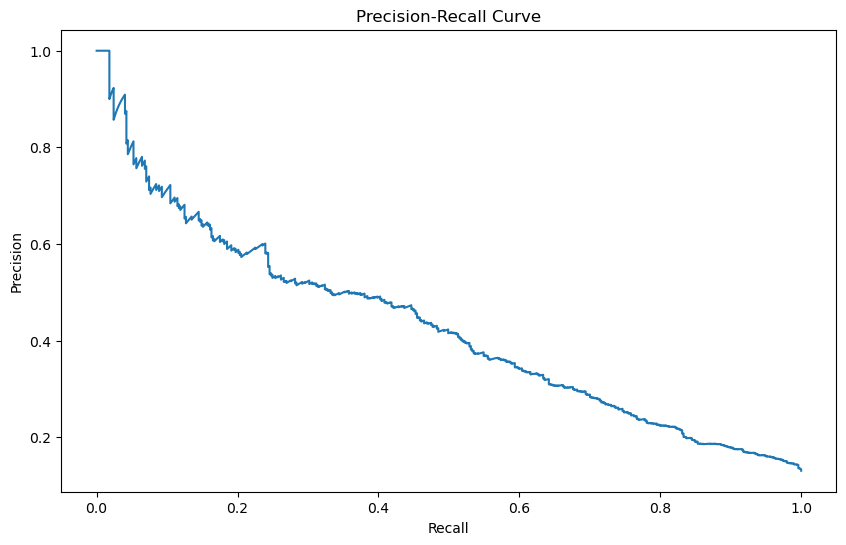

In [46]:
y_proba = rs_dem.predict_proba(X_test_dem_processed)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test_dem, y_proba)

# Plot to see your options
plt.figure(figsize=(10, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

for target_precision in [0.5, 0.55, 0.6, 0.65, 0.7, 0.8]:
    if np.any(precision >= target_precision):
        idx = np.argmax(precision >= target_precision)
        print(f"{idx}: Precision {target_precision:.2f} → Recall {recall[idx]:.3f} → Threshold {thresholds[idx]:.3f}")

In [49]:
best_threshold = 0.397 # Pick manually

y_test_tuned = (y_proba >= best_threshold).astype(int)

print("TEST SET (with Best Threshold):")
print(classification_report(y_test_dem, y_test_tuned))

TEST SET (with Best Threshold):
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      3299
           1       0.52      0.29      0.37       497

    accuracy                           0.87      3796
   macro avg       0.71      0.63      0.65      3796
weighted avg       0.85      0.87      0.86      3796



### 7. Save the Results

In [68]:
final_model = ml.ClassifierWithThresholdModel(
    pipeline=best_model,
    preprocessor=preprocessor,
    threshold=best_threshold,
)

ml.ClassifierWithThresholdModel.save_model(final_model, '../data/best_model_dem.joblib')

Model exported to ../data/best_model_dem.joblib


# C. Merge the 2 Models

In [60]:
# Load the entire dataset

youtube_db.cursor.execute(f"""
SELECT Comments.id, video_id, content, gemini_label, sentiment, emotion, bias, leaning, is_political
FROM CommentAnalysis JOIN Comments on Comments.id = CommentAnalysis.id
""")

data = youtube_db.cursor.fetchall()

df = pd.DataFrame(data)
df.columns = ['id', 'video_id', 'content', 'label', 'sentiment', 'emotion', 'bias', 'leaning', 'is_political']
df['label'] = [{'Neutral': 0, 'Republican': 1, 'Democratic': 2}.get(l) for l in df['label']]
df['podcast_guest'] = ['Trump' if video_id in trump_podcasts else 'Harris' for video_id in df['video_id']]
df.drop('video_id', axis=1, inplace=True)

df

,id,content,label,sentiment,emotion,bias,leaning,is_political,podcast_guest
0,UgyfluKW3Ug3sy7JipJ4AaABAg,Best Podcast of All-time? 🤔🔥,1.0,Positive,joy,RIGHT,RIGHT,0,Trump
1,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWgAZknY6,Definitely my favorite!,1.0,Positive,joy,RIGHT,LEFT,0,Trump
2,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpEh0att,"No, best guest",1.0,Positive,joy,RIGHT,RIGHT,0,Trump
3,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpMKmUEI,Probably,0.0,Neutral,anticipation,RIGHT,LEFT,0,Trump
4,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWt4CmVAq,Under 30 seconds,0.0,Neutral,anticipation,RIGHT,RIGHT,0,Trump
...,...,...,...,...,...,...,...,...,...
114695,UgyHorsmGTU9LHUXCBJ4AaABAg.AA9n_pk7NK3AA9xuMlvsYZ,How do you check the numbers from your phone ...,NaN,Negative,disgust,RIGHT,RIGHT,0,Harris
114696,UgyHorsmGTU9LHUXCBJ4AaABAg.AA9n_pk7NK3AA9yMqEcrPM,@@BruceDragon-sf1tr just google it fam. I prom...,NaN,Neutral,optimism,LEFT,RIGHT,0,Harris
114697,UgyHorsmGTU9LHUXCBJ4AaABAg.AA9n_pk7NK3AAA-zsorgCI,its now 34k to 88k now lolol,NaN,Positive,joy,LEFT,LEFT,0,Harris
114698,UgyHorsmGTU9LHUXCBJ4AaABAg.AA9n_pk7NK3AAA04ke2mdj,@@BruceDragon-sf1trjust add it to your browser...,NaN,Neutral,anger,LEFT,RIGHT,0,Harris


In [69]:
new_X = df[['id', 'content', 'podcast_guest', 'sentiment', 'emotion', 'bias', 'leaning', 'is_political']]

rep_model = ml.ClassifierWithThresholdModel.load_model('../data/best_model_rep.joblib')

dem_model = ml.ClassifierWithThresholdModel.load_model('../data/best_model_dem.joblib')

In [70]:
final_predictor = ml.StanceCrossPredictor(
    republican_model=rep_model,
    democratic_model=dem_model,
)

predictions = final_predictor.predict(new_X)

C:\Users\Filippo Corti\miniconda3\envs\SocialMediaMining\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [71]:
# Checkout predictions on the subset that has a label
# Disclaimer: it's the data the models have been trained on

df_with_labels = df[df['label'].notna()]

df_with_labels

,id,content,label,sentiment,emotion,bias,leaning,is_political,podcast_guest
0,UgyfluKW3Ug3sy7JipJ4AaABAg,Best Podcast of All-time? 🤔🔥,1.0,Positive,joy,RIGHT,RIGHT,0,Trump
1,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWgAZknY6,Definitely my favorite!,1.0,Positive,joy,RIGHT,LEFT,0,Trump
2,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpEh0att,"No, best guest",1.0,Positive,joy,RIGHT,RIGHT,0,Trump
3,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpMKmUEI,Probably,0.0,Neutral,anticipation,RIGHT,LEFT,0,Trump
4,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWt4CmVAq,Under 30 seconds,0.0,Neutral,anticipation,RIGHT,RIGHT,0,Trump
...,...,...,...,...,...,...,...,...,...
114649,UgwCaYjmWTVjWtNcl9V4AaABAg.AA7cVVMTlASAA8hHsViVmY,@@leroyjetson2329Folks with Caribbean heritage...,0.0,Negative,anticipation,LEFT,RIGHT,1,Harris
114671,UgyR6ug3JqspPes1zsR4AaABAg.AA9UwQXdpEiAA9_4M4OOI-,I am only here for the comment section.,0.0,Neutral,anger,RIGHT,RIGHT,0,Harris
114684,UgyR6ug3JqspPes1zsR4AaABAg.AA9UwQXdpEiAA9wSDvAdjX,😅😂 this comment section is trouble!,0.0,Negative,anger,RIGHT,LEFT,0,Harris
114689,UgyHorsmGTU9LHUXCBJ4AaABAg.AA9n_pk7NK3AA9tHqzb_hg,@@HI-DEF100 I’ve been looking for a positive c...,1.0,Neutral,sadness,LEFT,LEFT,0,Harris


In [63]:
X_test = df_with_labels[['content', 'podcast_guest', 'sentiment', 'emotion', 'bias', 'leaning', 'is_political']]
y_test = df_with_labels['label']

y_predictions = final_predictor.predict(X_test)

print(classification_report(y_test, y_predictions))

C:\Users\Filippo Corti\miniconda3\envs\SocialMediaMining\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.71      0.90      0.79     10466
         1.0       0.76      0.50      0.60      6029
         2.0       0.62      0.44      0.51      2483

    accuracy                           0.71     18978
   macro avg       0.70      0.61      0.63     18978
weighted avg       0.71      0.71      0.69     18978



In [72]:
Counter(predictions)

Counter({0: 81532, 1: 24543, 2: 8625})

In [73]:
# Save results in the DB
# Prepare data for bulk insert
update_data = [(label, id) for id, label in zip(df['id'], predictions)]

# Execute all at once
cursor = youtube_db.cursor
cursor.executemany(
    "UPDATE CommentAnalysis SET label = ? WHERE id = ?",
    update_data
)
youtube_db.conn.commit()